389867205
Initial State:
│ Current Time       │ Time Until End     │   
│          0         │        1020        │

  AC   Prob  Start   End |    F1  Dep1  Arr1 |    F2  Dep2  Arr2 |    F3  Dep3  Arr3 |    F4  Dep4  Arr4 |    F5  Dep5  Arr5 |    F6  Dep6  Arr6 |    F7  Dep7  Arr7 |    F8  Dep8  Arr8 |    F9  Dep9  Arr9 |   F10 Dep10 Arr10 |   F11 Dep11 Arr11 |   F12 Dep12 Arr12
   1   0.00    135   411 |     2   257   649 |     3   863  1087 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   2   1.00    121   826 |     4    75   290 |     5   316   569 |     6   605  1087 |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     - |     -     -     -
   3   0.00    129   277 |     7     3   195 |     9   660   843 |     -     -     - |  

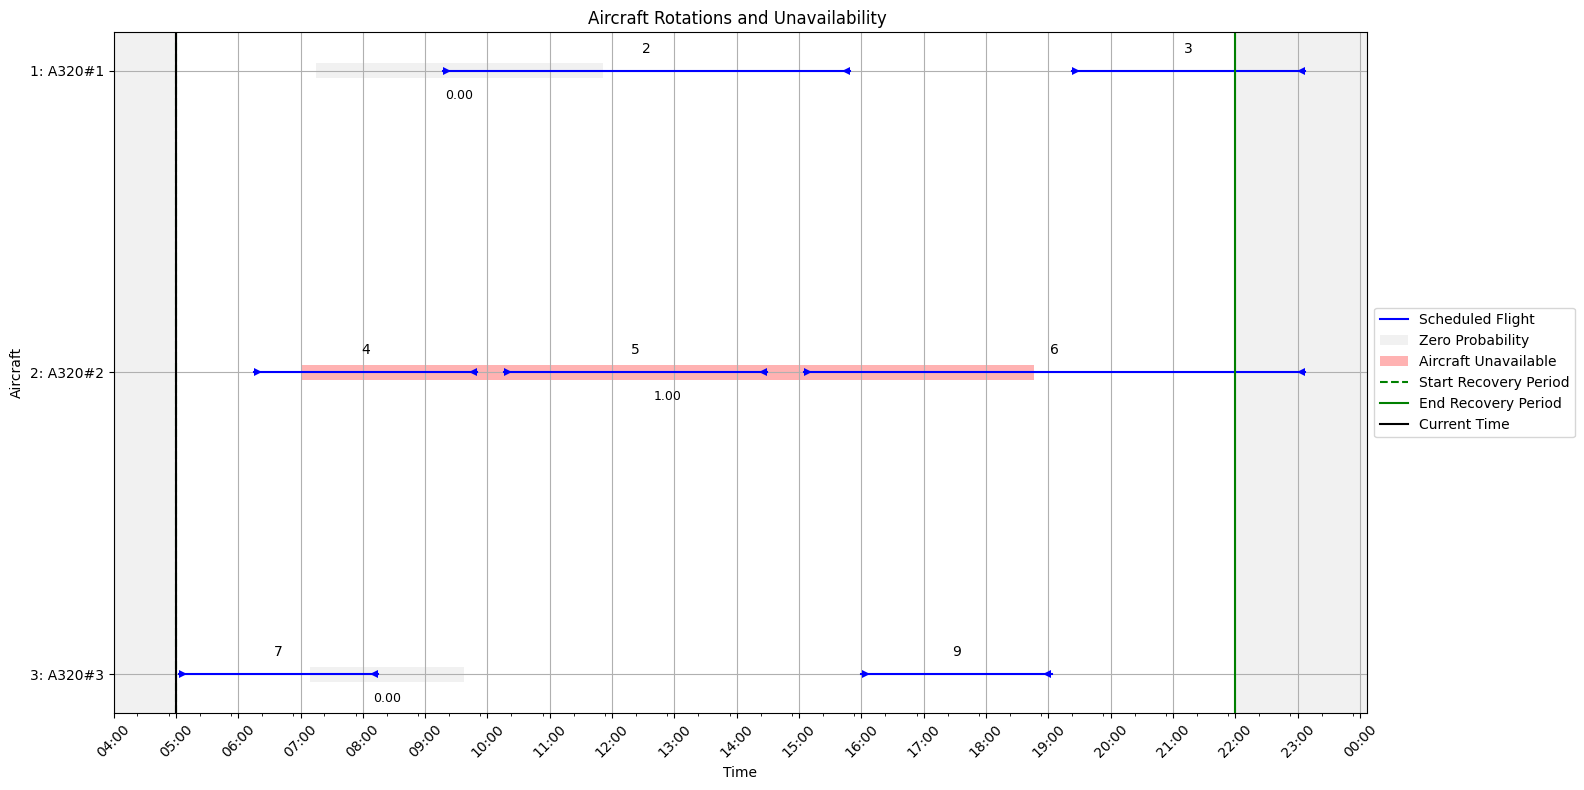


Available Actions:
Action chosen: Flight 2, Aircraft 3

Reward for action: flight 2, aircraft 3
  +0 for resolving 0 conflicts (excluding cancellations): set()
  -0.0 for delays (0 minutes)
  -0 penalty for cancelled flights
  -0 for inaction with conflicts
  +25.700000000000003 bonus for proactive action (257.0 minutes ahead)
  -60.0 penalty for time passed
_______________
-34.3 total reward for action: flight 2, aircraft 3
Action taken: Flight 2, Aircraft 3, Reward: -34.3

Step 1:


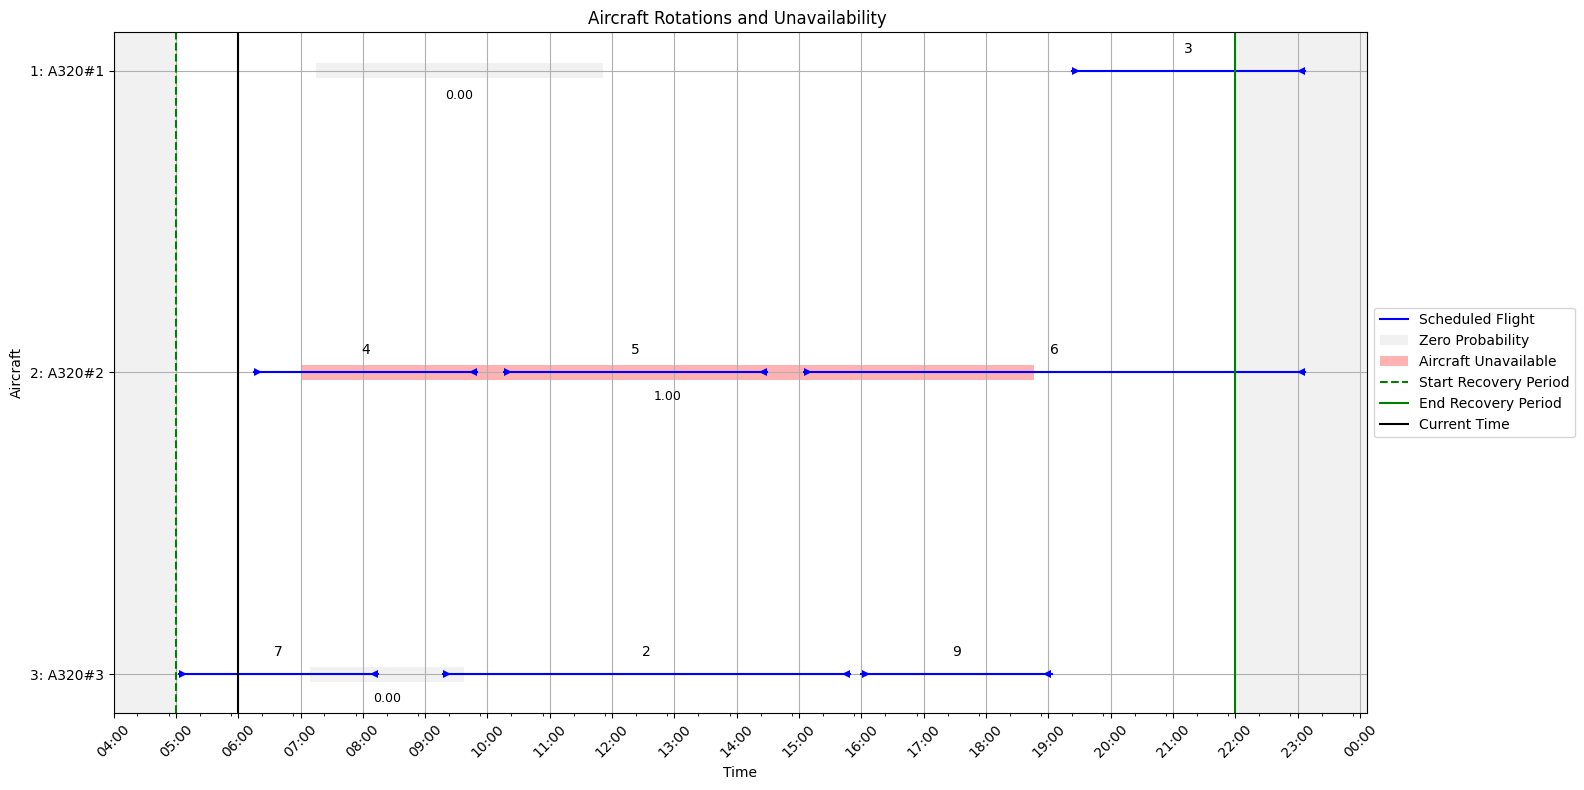


Available Actions:
Action chosen: Flight 4, Aircraft 1

Reward for action: flight 4, aircraft 1
  +10000 for resolving 1 conflicts (excluding cancellations): {('A320#2', 4.0, 75.0, 290.0)}
  -0.0 for delays (0 minutes)
  -0 penalty for cancelled flights
  -0 for inaction with conflicts
  +1.5 bonus for proactive action (15.0 minutes ahead)
  -120.0 penalty for time passed
_______________
9881.5 total reward for action: flight 4, aircraft 1
Action taken: Flight 4, Aircraft 1, Reward: 9881.5

Step 2:


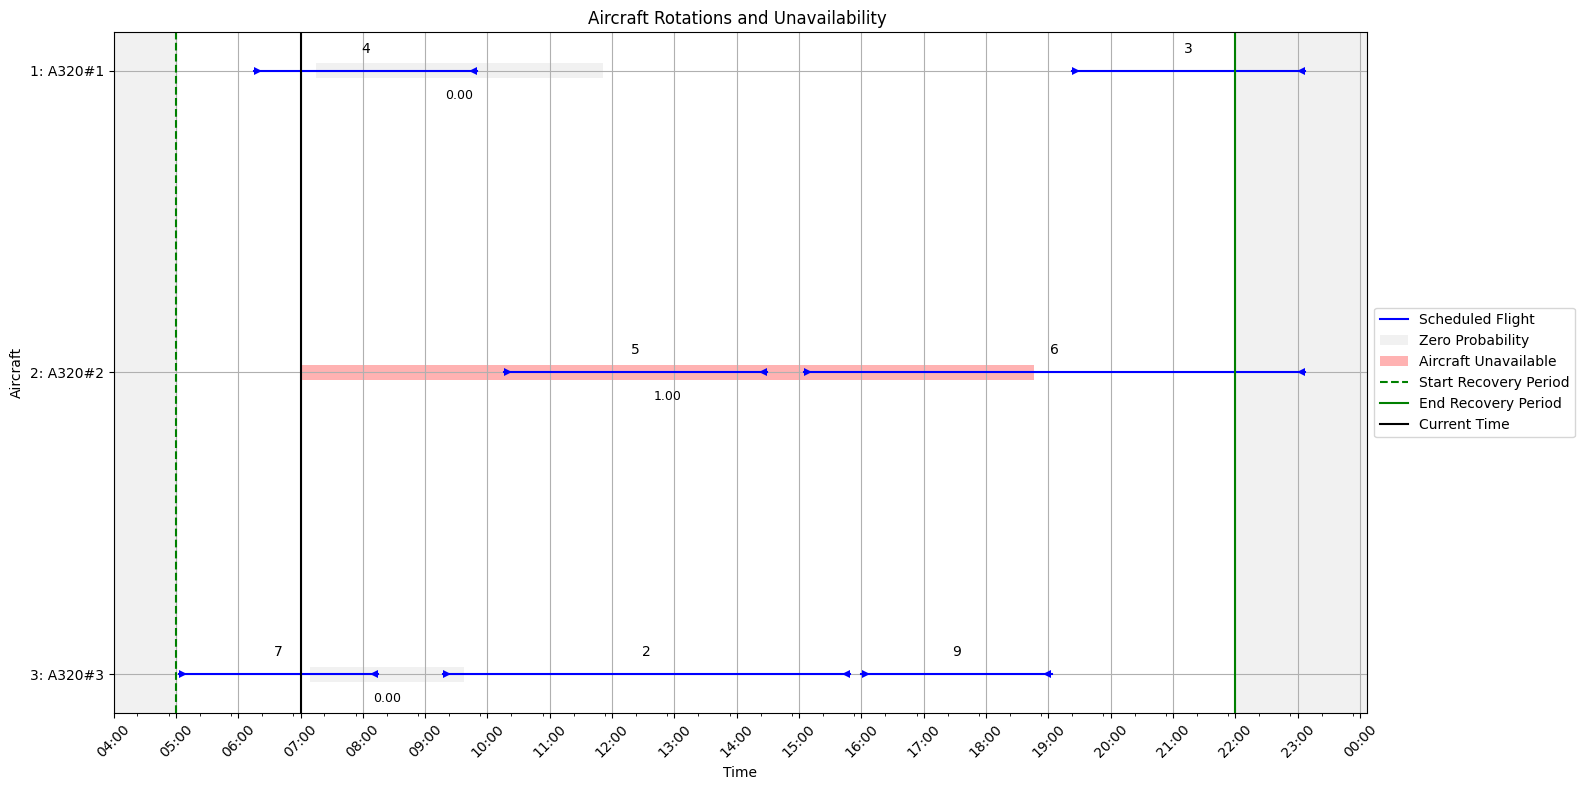


Available Actions:
Action chosen: Flight 5, Aircraft 1

Reward for action: flight 5, aircraft 1
  +10000 for resolving 1 conflicts (excluding cancellations): {('A320#2', 5.0, 316.0, 569.0)}
  -0.0 for delays (0 minutes)
  -0 penalty for cancelled flights
  -0 for inaction with conflicts
  +19.6 bonus for proactive action (196.0 minutes ahead)
  -180.0 penalty for time passed
_______________
9839.6 total reward for action: flight 5, aircraft 1
Action taken: Flight 5, Aircraft 1, Reward: 9839.6

Step 3:


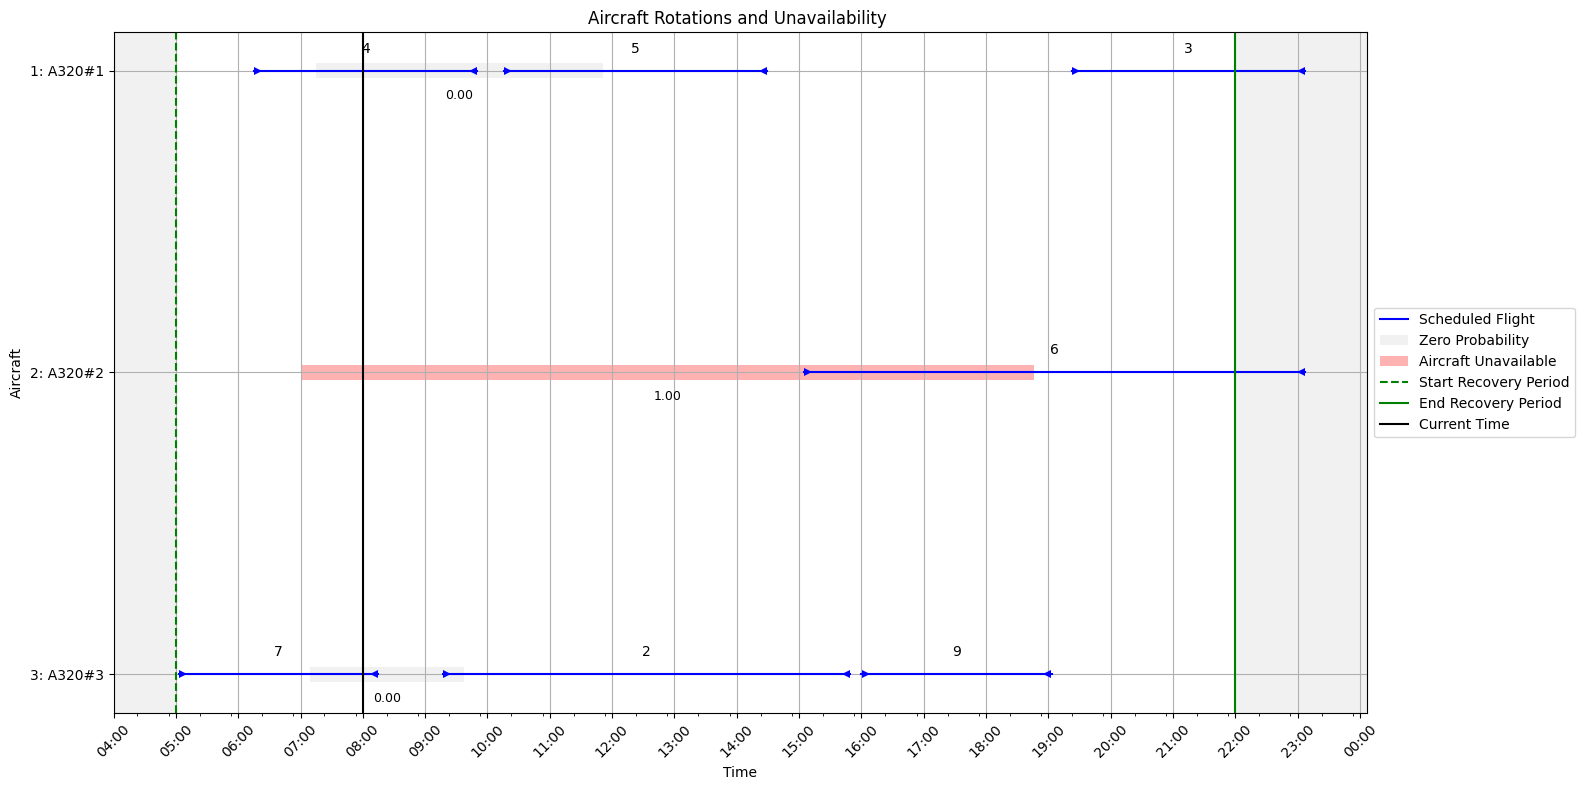


Available Actions:
Invalid input. Please enter a number corresponding to the action index.


KeyboardInterrupt: Interrupted by user

In [1]:
import os
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta
from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter
from src.config import TIMESTEP_HOURS
import time

env_type = "proactive"

# Function to handle user input for action
def get_user_action(valid_actions, env):
    print("\nAvailable Actions:")
    # for action_index in valid_actions:
    #     flight, aircraft = env.map_index_to_action(action_index)
    #     print(f"Index {action_index}: Flight {flight}, Aircraft {aircraft}")

    while True:
        try:
            user_input = input("Enter the flight index from the available flights: ").strip()
            flight_index = int(user_input)

            user_input = input("Enter the aircraft index from the available aircrafts: ").strip()
            aircraft_index = int(user_input)

            action_index = env.map_action_to_index(flight_index, aircraft_index)

            if action_index in valid_actions:
                return action_index
            else:
                print("Invalid action index. Please select from the valid actions.")
        except ValueError:
            print("Invalid input. Please enter a number corresponding to the action index.")

# Run the agent with user input
def run_user_agent(scenario_folder):
    # Set a random seed based on the current second in time
    current_seed = int(time.time() * 1e9) % (2**32 - 1)
    print(current_seed)
    np.random.seed(current_seed)

    # Load the scenario data
    data_dict = load_scenario_data(scenario_folder)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(
        aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict, env_type=env_type
    )

    # Reset the environment
    obs, info = env.reset()
    if DEBUG_MODE_VISUALIZATION:
        print("Observation keys:", obs.keys())

    done = False
    total_reward = 0
    step_num = 0

    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=env.aircraft_dict,
        flights_dict=env.flights_dict,
        rotations_dict=env.rotations_dict,
        alt_aircraft_dict=env.alt_aircraft_dict,
        start_datetime=env.start_datetime,
        end_datetime=env.end_datetime,
        uncertain_breakdowns=env.uncertain_breakdowns,
    )

    # Print initial state
    print("Initial State:")
    print_state_nicely_proactive(env.state)

    while not done:
        # Visualize the environment at each step
        print(f"\nStep {step_num}:")

        # Extract necessary information for plotting
        swapped_flights = env.swapped_flights
        environment_delayed_flights = env.environment_delayed_flights
        current_datetime = env.current_datetime

        updated_flights_dict = env.flights_dict
        updated_rotations_dict = env.rotations_dict
        updated_alt_aircraft_dict = env.alt_aircraft_dict
        cancelled_flights = env.penalized_cancelled_flights

        # Update the StatePlotter's dictionaries
        state_plotter.alt_aircraft_dict = updated_alt_aircraft_dict
        state_plotter.flights_dict = updated_flights_dict
        state_plotter.rotations_dict = updated_rotations_dict

        # Plot the state
        state_plotter.plot_state(
            updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime
        )

        # Get the action mask
        action_mask = obs['action_mask']
        valid_actions = np.where(action_mask == 1)[0]

        if len(valid_actions) == 0:
            print("No valid actions available. Terminating...")
            break

        # Get user input for the action
        action_index = get_user_action(valid_actions, env)

        # Map the action index to the actual action
        action = env.map_index_to_action(action_index)
        print(f"Action chosen: Flight {action[0]}, Aircraft {action[1]}")

        # Step the environment
        obs, reward, terminated, truncated, info = env.step(action_index)
        done = terminated or truncated

        # Accumulate reward
        total_reward += reward

        # Print action and reward
        print(f"Action taken: Flight {action[0]}, Aircraft {action[1]}, Reward: {reward}")

        step_num += 1

    # Final plot after the simulation ends
    state_plotter.plot_state(
        updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights,
        current_datetime + timedelta(hours=TIMESTEP_HOURS)
    )

    print(f"Total Reward: {total_reward}")

# Set the scenario folder
SCENARIO_FOLDER = "../data/Locked/alpha/Scenario_01"

# Verify folder exists
if not os.path.exists(SCENARIO_FOLDER):
    raise FileNotFoundError(f"Scenario folder not found: {SCENARIO_FOLDER}")

# Run the agent
run_user_agent(SCENARIO_FOLDER)
